###Canvas Creation from Enrichr

In [40]:
import pandas as pd 
import json
import requests
import math
import matplotlib
import uuid

import matplotlib.pyplot as plt
from time import time

from textwrap import dedent
from IPython.core.display import display, HTML
from string import Template
from random import seed, randint
from operator import itemgetter

Below this is arbitrary definitions for these variables, their actual values will be selected in the Appyter (so DON'T ADD BELOW CELL TO APPYTER)

In [41]:
bar_color = 'mediumforestgreen'
bar_color_not_sig = 'lightgrey'
edgecolor = None
chart_type = "Canvas"
all_libraries = ['WikiPathways_2019_Human']
color = 'Purple'
scaling_factor = ''
num_hex_colored = 10

# list of genes that was input

open_gene_list_file = open('geneList.txt','r')
lines = open_gene_list_file.readlines()
genes = [x.strip().upper() for x in lines]
open_gene_list_file.close()

#genes = ['TP53', 'TNF', 'EGFR', 'GKN1', 'HADHA', 'APOE', 'ESR1', 'VEGFA', 'TGFB1', 'PREPL', 'TIA1', 'TPO', 'TTN', 'SATB2', 'CHPF', 'MALL', 'MIPIP', 'NUPL1', 'IL6', 'PDIA3', 'CTNNB1', 'SLC39A1', 'DTNA','SLC1A1', 'GALNT2', 'HIST2H2AC', 'CD63']

In [42]:
def library_processing(index):
    '''processes library data. returns anneal_list, x_dimension, y_dimension, num_hex'''
    raw_library_data = []
    library_data = []

    library_name = all_libraries[index]
    with open('Enrichr-Libraries/'+library_name, 'r') as f:
        for line in f.readlines():
            raw_library_data.append(line.split("\t\t"))
    name = []
    gene_list = []

    for i in range(len(raw_library_data)):
        name += [raw_library_data[i][0]]
        raw_genes = raw_library_data[i][1].split("\t")
        gene_list += [raw_genes[:-1]]

    library_data = [list(a) for a in zip(name, gene_list)]

    # library_data: a 2D list where the first element is the name and the second element is a list      of genes associated with that name

    jaccard_indices = []
    indices = []

    for gene_set in library_data:
        intersection = [value for value in gene_set[1] if value in genes]
        index = len(intersection)/(len(gene_set[1]) + len(genes))
        jaccard_indices += [[gene_set[0], index]]
        indices += [round(index, 5)]

    # determine the dimensions of the canvas
    x_dimension = math.ceil(math.sqrt(len(indices)))
    y_dimension = math.ceil(math.sqrt(len(indices)))

    # Zip name, gene_list, indices, and blank list for neighbor score then add dummy entries to the      zipped list
    num_hex = x_dimension*y_dimension
    neighbor_score = [0.0] * len(name)
    anneal_list = list(zip(name, gene_list, indices, neighbor_score))

    unzipped_anneal_list = [name, gene_list, indices, neighbor_score]

    # Add "dummy" hexagons
    for i in range(len(name), num_hex):
        anneal_list += [('', [], 0.0, 0.0)]

    return anneal_list, x_dimension, y_dimension, num_hex

In [43]:
def get_color(anneal_list, cut_off_value):

    # Deal with cut_off_value (only color the most significant 10/20 hexagons)
    if cut_off_value == 2.0:
        sort_list = sorted(anneal_list, key=itemgetter(2), reverse=True)
        cut_off_value = sort_list[num_hex_colored-1][2]

    r_value = 0
    g_value = 0
    b_value = 0

    if color == 'Red':
        r_value = 0.0
        g_value = 0.8
        b_value = 0.8
    if color == 'Yellow':
        r_value = 0.0
        g_value = 0.3
        b_value = 1.0
    if color == 'Purple':
        r_value = 0.5
        g_value = 1.0
        b_value = 0.0
    if color == 'Pink':
        r_value = 0.0
        g_value = 1.0
        b_value = 0.2
    if color == 'Orange':
        r_value = 0.0
        g_value = 0.45
        b_value = 1.0
    if color == 'Green':
        r_value = 1.0
        g_value = 0.0
        b_value = 1.0
    if color == 'Blue':
        r_value = 1.0
        g_value = 0.9
        b_value = 0.0

    color_list = []

    unzipped_anneal_list = unzip_list(anneal_list)
    
    if scaling_factor == '':
        max_index = max(unzipped_anneal_list[2])
    else:
        max_index = float(scaling_factor)

    scaled_list = [i/max_index for i in unzipped_anneal_list[2]]

    for i in range(x_dimension*y_dimension):
        if i < len(unzipped_anneal_list[2]) and float(unzipped_anneal_list[2][i]) >= cut_off_value:
            color_list += [matplotlib.colors.to_hex((1-scaled_list[i]*r_value, 
            1-scaled_list[i]*g_value, 1-scaled_list[i]*b_value))]
        elif i < len(unzipped_anneal_list[2]):
            color_list += [matplotlib.colors.to_hex((1-scaled_list[i], 
            1-scaled_list[i], 1-scaled_list[i]))]
        else:
            color_list += ["#FFFFFF"]
    return color_list, max_index, cut_off_value

In [44]:
def find_neighbors(ind):
    '''returns a list of the indices of the neighbors of the index given'''
    neighbors = []
    if 0 <= ind <= x_dimension-1:
        # top row (inc. corners)
        if ind == 0:
            # top left corner
            neighbors = [num_hex-1, num_hex-x_dimension, x_dimension-1, 2*x_dimension-1, ind+1,                  ind+x_dimension]
        elif ind == (x_dimension-1):
            # top right corner
            neighbors = [ind-1, ind+x_dimension, 0, ind+x_dimension-1, num_hex-2, num_hex-1]
        else:
            # non-corner top row
            neighbors = [ind-1, ind+1, ind+x_dimension, ind+num_hex-x_dimension-1, 
            ind+num_hex-x_dimension, ind+x_dimension-1]

    elif (num_hex - x_dimension) <= ind <= num_hex -1:
        if ind == (num_hex-x_dimension):
            # bottom left corner
            neighbors = [ind+1, ind-x_dimension, ind-x_dimension+1, 0, 1, num_hex-1]
        elif ind == (num_hex-1):
            # bottom right corner
            neighbors = [ind-1, ind-x_dimension, ind-x_dimension+1, 0, x_dimension-1,
            num_hex-2*x_dimension]
        else:
            # non-corner bottom row
            neighbors = [ind-1, ind+1, ind-x_dimension, ind-x_dimension+1, ind-num_hex+x_dimension,
            ind-num_hex+x_dimension+1]
    elif ind % y_dimension == 0 and (ind/y_dimension)%2 == 1:
        # "inner" left edge (not top or bottom row)
        neighbors = [ind+x_dimension-1, ind+1, ind-x_dimension, ind-x_dimension+1, ind+x_dimension, 
        ind+x_dimension+1]
    elif ind % y_dimension == 0 and (ind/y_dimension)%2 == 0:
        # "outer" left edge (not top or bottom row)
        neighbors = [ind-1, ind+1, ind+x_dimension, ind+2*x_dimension-1, ind-x_dimension, 
        ind+x_dimension-1]
    elif (ind+1) % y_dimension == 0 and ((ind+1)/y_dimension)%2 == 0:
        # "outer" right edge (not top or bottom row)
        neighbors = [ind-1, ind+1, ind-x_dimension, ind-x_dimension+1, ind+x_dimension, 
        ind-2*x_dimension+1]
    elif (ind+1) % y_dimension == 0 and ((ind+1)/y_dimension)%2 == 1:
        # "inner" right edge (not top or bottom row)
        neighbors = [ind-1, ind-x_dimension-1, ind-x_dimension, ind-x_dimension+1, ind+x_dimension, 
        ind+x_dimension-1]
    else:
        # middle
        neighbors = [ind-1, ind+1, ind-x_dimension, ind-x_dimension+1, ind+x_dimension, 
        ind+x_dimension+1]
    return neighbors

In [45]:
# initially find fitness
def find_fitness(anneal_list):
    fitness = 0
    for i in range(len(anneal_list)):
        neighbors = find_neighbors(i)
        sum_neighbor_score = 0
        for index in neighbors:
            intersection = [value for value in anneal_list[index][1] if value in anneal_list[i][1]]
            if len(anneal_list[index][1]) + len(anneal_list[i][1]) != 0:
                jaccard = len(intersection)/(len(anneal_list[index][1]) + len(anneal_list[i][1]))
            else:
                jaccard = 0.0
            sum_neighbor_score += jaccard
        hex_list = list(anneal_list[i])
        hex_list[3] = sum_neighbor_score
        hex_tuple = tuple(hex_list)
        anneal_list[i] = hex_tuple
        fitness += sum_neighbor_score
    return fitness, anneal_list

# take indices of swapped hexagons
def find_swapped_fitness(anneal_list, swapped_a, swapped_b, old_fitness):
    neighbors_a = find_neighbors(swapped_a)
    neighbors_b = find_neighbors(swapped_b)
    hexagons_to_update = [swapped_a, swapped_b] + neighbors_a + neighbors_b
    anneal_copy = anneal_list.copy()

    new_fitness = 0
    # Recalculate scores for all hexagons that need updating
    for hex in hexagons_to_update:

        # subtract out the swapped neighbor fitnesses because they are changing 
        old_fitness -= anneal_copy[hex][3]

        neighbors = find_neighbors(hex)
        sum_neighbor_score = 0
        for index in neighbors:
            intersection = [value for value in anneal_copy[index][1] if value in anneal_copy[hex][1]]
            if len(anneal_copy[index][1]) + len(anneal_copy[hex][1]) != 0:
                jaccard = len(intersection)/(len(anneal_copy[index][1]) + len(anneal_copy[hex][1]))
            else:
                jaccard = 0.0
            sum_neighbor_score += jaccard
        hex_list = list(anneal_copy[hex])
        hex_list[3] = sum_neighbor_score
        hex_tuple = tuple(hex_list)
        anneal_copy[hex] = hex_tuple
        new_fitness += sum_neighbor_score
        
    return old_fitness + new_fitness, anneal_copy

In [46]:
def unzip_list(anneal_list):
    unzipped_list = zip(*anneal_list)
    return list(unzipped_list)

In [47]:
def annealing(anneal_list, steps, old_fitness):
    list_of_fitnesses = []
    useful_swaps = 0
    bad_swaps = 0
    # returns unzipped list
    for i in range(steps):
        index_a = randint(0, num_hex-1)
        index_b = randint(0, num_hex-1)
        anneal_list[index_a], anneal_list[index_b] = anneal_list[index_b], anneal_list[index_a]
        new_fitness, new_anneal_list = find_swapped_fitness(anneal_list, index_a, index_b, old_fitness)

        if new_fitness <= old_fitness:
            # swap back
            anneal_list[index_a], anneal_list[index_b] = anneal_list[index_b], anneal_list[index_a]
            list_of_fitnesses += [old_fitness]
            bad_swaps += 1
        else:
            # finalize the swap by resetting old_fitness and changing anneal_list
            old_fitness = new_fitness
            anneal_list = new_anneal_list
            list_of_fitnesses += [old_fitness]
            useful_swaps += 1
    return anneal_list, list_of_fitnesses, useful_swaps, bad_swaps

In [48]:
def init_chart():
  chart_id = 'mychart-' + str(uuid.uuid4())
  display(HTML('<script src="/static/components/requirejs/require.js"></script>'))
  display(HTML(Template(dedent('''
  <script>
  require.config({
    paths: {
      'd3': 'https://cdnjs.cloudflare.com/ajax/libs/d3/5.16.0/d3.min',
      'd3-hexbin': 'https://d3js.org/d3-hexbin.v0.2.min',
    },
    shim: {
      'd3-hexbin': ['d3']
    }
  })

  // If we configure mychart via url, we can eliminate this define here
  define($chart_id, ['d3', 'd3-hexbin'], function(d3, d3_hexbin) {
    return function (figure_id, numA, numB, colorList, libraryList, indices) {
      var margin = {top: 50, right: 20, bottom: 20, left: 50},
        width = 850 - margin.left - margin.right,
        height = 350 - margin.top - margin.bottom;

      // append the svg object to the body of the page
      var svG = d3.select('#' + figure_id)
                  .attr("width", width + margin.left + margin.right)
                  .attr("height", height + margin.top + margin.bottom)
                  .append("g")
                  .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
      
      //The number of columns and rows of the heatmap
      var MapColumns = numA,
          MapRows = numB;

      //The maximum radius the hexagons can have to still fit the screen
      var hexRadius = d3.min([width/((MapColumns + 0.5) * Math.sqrt(3)), height/((MapRows + 1/3) * 1.5)]);

      //Calculate the center position of each hexagon
      var points = [];
      for (var i = 0; i < MapRows; i++) {
          for (var j = 0; j < MapColumns; j++) {
              var x = hexRadius * j * Math.sqrt(3)
              //Offset each uneven row by half of a "hex-width" to the right
              if(i%2 === 1) x += (hexRadius * Math.sqrt(3))/2
              var y = hexRadius * i * 1.5
              points.push([x,y])
          }
      }

      //Set the hexagon radius
      var hexbin = d3_hexbin.hexbin().radius(hexRadius);

      svG.append("g")
        .selectAll(".hexagon")
        .data(hexbin(points))
        .enter().append("path")
        .attr("class", "hexagon")
        .attr("d", function (d) {
            return "M" + d.x + "," + d.y + hexbin.hexagon();
        })
        .attr("stroke", "black")
        .attr("stroke-width", "1px")
        .style("fill", function (d,i) { return colorList[i]; })
        .on("mouseover", mover)
        .on("mouseout", mout)
        .append("svg:title")
        .text(function(d,i) { return libraryList[i].concat(" ").concat(indices[i]); });

      // Mouseover function
      function mover(d) {
      d3.select(this)
        .transition().duration(10)  
        .style("fill-opacity", 0.3)
      };

      // Mouseout function
      function mout(d) { 
      d3.select(this)
        .transition().duration(10)
        .style("fill-opacity", 1)
      };

  }

  })
  </script>
  ''')).substitute({ 'chart_id': repr(chart_id) })))
  return chart_id

def Canvas(numA, numB, colorList, libraryList, indices):
  chart_id = init_chart()
  display(HTML(Template(dedent('''
  <svg id=$figure_id></svg>
  <script>
  require([$chart_id], function(mychart) {
    mychart($figure_id, $numA, $numB, $colorList, $libraryList, $indices)
  })
  </script>
  ''')).substitute({
      'chart_id': repr(chart_id),
      'figure_id': repr('fig-' + str(uuid.uuid4())),
      'numA': repr(numA),
      'numB': repr(numB),
      'colorList': repr(color_list),
      'libraryList': repr(list(unzipped_anneal_list[0])),
      'indices': repr(list(unzipped_anneal_list[2]))
  })))

In [49]:
anneal_list, x_dimension, y_dimension, num_hex = library_processing(0)
color_list, scaling_factor, cut_off_value = get_color(anneal_list, 2.0)
unzipped_anneal_list = unzip_list(anneal_list)
Canvas(x_dimension, y_dimension, color_list, list(unzipped_anneal_list[0]), list(unzipped_anneal_list[2]))
print("The scaling factor for this canvas is: " + str(scaling_factor))
print("Gene sets with a similarity index less than " + str(cut_off_value) + " are not colored.")

The scaling factor for this canvas is: 0.01073
Gene sets with a similarity index less than 0.00696 are not colored.


In [50]:
#anneal_list, x_dimension, y_dimension, num_hex = library_processing(0)
t = time()
anneal_list, list_of_fitnesses, useful_swaps, bad_swaps = annealing(anneal_list, 250000, find_fitness(anneal_list)[0])
color_list, scaling_factor, cut_off_value = get_color(anneal_list, cut_off_value)
unzipped_anneal_list = unzip_list(anneal_list)
Canvas(x_dimension, y_dimension, color_list, list(unzipped_anneal_list[0]), list(unzipped_anneal_list[2]))
print("The scaling factor for this canvas is: " + str(scaling_factor))
print("The time it took is: ", time()-t)

The scaling factor for this canvas is: 0.01073
The time it took is:  604.0297541618347


250000


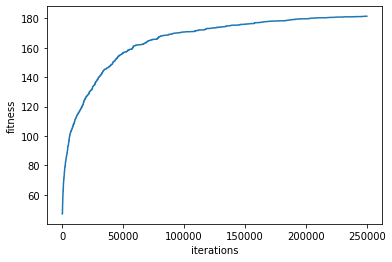

46.967501265127545
181.411239683273
179.19793876057855
useful swaps: 1686
bad swaps: 248314


In [51]:
print(len(list_of_fitnesses))
plt.plot(list(range(len(list_of_fitnesses))), list_of_fitnesses)
plt.ylabel("fitness")
plt.xlabel("iterations")
plt.show()
print(list_of_fitnesses[0])
print(max(list_of_fitnesses))
print(find_fitness(anneal_list)[0])
print("useful swaps: " + str(useful_swaps))
print("bad swaps: " + str(bad_swaps))

In [52]:
unzipped_anneal_list = unzip_list(anneal_list)
print(sum(unzipped_anneal_list[3]))
print(find_fitness(anneal_list)[0])

179.19793876057855
179.19793876057855
